# Figure 4: Total ionized hydrogen profile from ionization models.

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import QTable
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle


In [4]:
# Load Full Data
full_ideal_res = QTable.read("Data/Full_Ideal_CloudyResults_wNHII.fits")

# Load High Ion Results
with open("Data/HIGH_ION_DATA_wHII.pkl", "rb") as f:
    high_ion_data = pickle.load(f)

In [3]:
# Get summed HII columns per sightline
source_names = ['PKS0637-75',
 'HE0246-4101',
 'RBS144',
 'PKS0552-640',
 'PKS0202-76',
 'HE0003-5023',
 'UVQSJ045415.95-611626.6',
 'HE0419-5657',
 'UKS0242-724',
 'IRAS_F21325-6237',
 'IRAS_Z06229-6434',
 'RBS567',
 'PKS0558-504',
 'RX_J0503.1-6634',
 '1H0419-577',
 'RBS1992',
 'ESO031-G08',
 'PKS0355-483',
 'HE0153-4520',
 'HE0439-5254',
 'HE0038-5114',
 'HE0226-4110',
 'HE2336-5540',
 'RBS563',
 'HE0331-4112',
 'HE0435-5304',
 'HE2305-5315',
 'FAIRALL9']
summed_N_HII, impact_pars, sn, low_logT, low_logT_err  = [], [], [], [], []
for source_name in source_names:
    res_rows = full_ideal_res[full_ideal_res["SOURCE"] == source_name]
    if len(res_rows) > 0:
        N_HII = np.sum(res_rows["N_HII"])
        summed_N_HII.append(N_HII.value)
        impact_pars.append(res_rows["LMC_B"][0].value)
        sn.append(source_name)
        low_logT.append(np.log10(np.mean(res_rows["Te"]).value))
        low_logT_err.append(1/np.log(10) * np.std(res_rows["Te"]).value/np.mean(res_rows["Te"]).value)
    
summed_N_HII = np.array(summed_N_HII)*u.cm**-2
impact_pars = np.array(impact_pars)*u.kpc
sn = np.array(sn)
low_logT = np.array(low_logT)
low_logT_err = np.array(low_logT_err)

In [5]:
# Specify Bridge and Stream Directions
bridge_directions = [
    "PKS0202-76",
    "UKS0242-724",
    "ESO031-G08"
]


stream_directions = [
    "RBS144",
    "HE0226-4110",
    "HE0153-4520",
    "FAIRALL9"
]

stream_mask = np.array([n in stream_directions for n in sn])
stream_Bs = impact_pars.value[stream_mask]

bridge_mask = np.array([n in bridge_directions for n in sn])
bridge_Bs = impact_pars.value[bridge_mask]

rest_mask = ~stream_mask & ~bridge_mask

## Mass Calculations

In [6]:
distance = 50*u.kpc
from astropy.constants import m_p as proton_mass

In [7]:
from scipy.stats import siegelslopes
from seaborn.algorithms import bootstrap

### Photoionized Phase

In [10]:
# Slope Finding method for bootstrapping Photoionized CGM
def slope_finder(inds, y = np.log10(summed_N_HII.value), x = impact_pars):
    xx = x[inds]
    yy = y[inds]
    return siegelslopes(yy, x = xx)

In [11]:
slope, intercept = bootstrap(np.arange(len(impact_pars)), func = slope_finder, n_boot = 10000).T

In [12]:
mean_slope = slope.mean()
std_slope = slope.std()

In [13]:
xx = np.linspace(0,50,1000)
all_lines = np.array([m*xx + b for (m,b) in zip(slope,intercept)])
lo, med, hi = np.percentile(all_lines, (16,50,84), axis = 0)


dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**all_lines)*u.cm**(-2)


summed_masses_50_kpc = np.sum(mass.to(u.Msun), axis = 1)
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))

minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
log_med_mass = np.log10(med_mass.value)

### Magellanic Corona

#### Equilibrium

In [14]:
b_mask = high_ion_data["b"] > 7.

mask = np.isnan(high_ion_data["HII_err"])
mask |= np.isinf(high_ion_data["HII_err"])
mask |= np.isnan(high_ion_data["HII"])
mask |= np.isinf(high_ion_data["HII"])

Xin = high_ion_data["b"][~mask & b_mask]
Yin = high_ion_data["HII"][~mask & b_mask]
Yerr_in = high_ion_data["HII_err"][~mask & b_mask]

def slope_finder(inds, y = Yin, x = Xin, y_err = Yerr_in):
    ylen = len(y)
    y = y+y_err*np.random.randn(ylen)
    xx = x[inds]
    yy = y[inds]
    return siegelslopes(yy, x = xx)

gt7_slopes, gt7_intercepts = bootstrap(np.arange(len(Xin)), func = slope_finder, n_boot = 50000).T

In [16]:
gt7_first_mean_yint_C = gt7_intercepts.mean()
gt7_first_mean_slope_C = gt7_slopes.mean()

gt7_first_std_yint_C = gt7_intercepts.std()
gt7_first_std_slope_C = gt7_slopes.std()

xx = np.linspace(0,50,1000)
gt7_first_all_lines_C = np.array([m*xx + b for (m,b) in zip(gt7_slopes, gt7_intercepts)])

gt7_first_lo_line_C, gt7_first_med_line_C, gt7_first_hi_line_C = np.percentile(gt7_first_all_lines_C, 
                                                                   (16,50,84), axis = 0)
gt7_first_mean_line_C = gt7_first_mean_slope_C*xx + gt7_first_mean_yint_C

In [19]:
dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**gt7_first_all_lines_C)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc = np.sum(mass[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc += np.sum(mass[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))
minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

gt7_first_C_log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
gt7_first_C_log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
gt7_first_C_log_med_mass = np.log10(med_mass.value)

<ipython-input-19-b2abc45ff335>:3: RuntimeWarning: overflow encountered in power
  mass = dA * proton_mass * (10**gt7_first_all_lines_C)*u.cm**(-2)


#### Time-Dependent Isochoric

In [15]:


mask = np.isnan(high_ion_data["ISOCh_HII_err"])
mask |= np.isinf(high_ion_data["ISOCh_HII_err"])
mask |= np.isnan(high_ion_data["ISOCh_HII"])
mask |= np.isinf(high_ion_data["ISOCh_HII"])

Xin = high_ion_data["b"][~mask & b_mask]
Yin = high_ion_data["ISOCh_HII"][~mask & b_mask]
Yerr_in = high_ion_data["ISOCh_HII_err"][~mask & b_mask]

def slope_finder(inds, y = Yin, x = Xin, y_err = Yerr_in):
    ylen = len(y)
    y = y+y_err*np.random.randn(ylen)
    xx = x[inds]
    yy = y[inds]
    return siegelslopes(yy, x = xx)

ISOCh_gt7_slopes, ISOCh_gt7_intercepts = bootstrap(np.arange(len(Xin)), func = slope_finder, n_boot = 50000).T

In [17]:
ISOCh_gt7_mean_yint_C = ISOCh_gt7_intercepts.mean()
ISOCh_gt7_mean_slope_C = ISOCh_gt7_slopes.mean()

ISOCh_gt7_std_yint_C = ISOCh_gt7_intercepts.std()
ISOCh_gt7_std_slope_C = ISOCh_gt7_slopes.std()

xx = np.linspace(0,50,1000)
ISOCh_gt7_all_lines_C = np.array([m*xx + b for (m,b) in zip(ISOCh_gt7_slopes, ISOCh_gt7_intercepts)])

ISOCh_gt7_lo_line_C, ISOCh_gt7_med_line_C, ISOCh_gt7_hi_line_C = np.percentile(ISOCh_gt7_all_lines_C, 
                                                                   (16,50,84), axis = 0)
ISOCh_gt7_mean_line_C = ISOCh_gt7_mean_slope_C*xx + ISOCh_gt7_mean_yint_C

In [18]:
dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**ISOCh_gt7_all_lines_C)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc = np.sum(mass[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc += np.sum(mass[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))
minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

ISOCh_gt7_C_log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
ISOCh_gt7_C_log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
ISOCh_gt7_C_log_med_mass = np.log10(med_mass.value)

## Figure 4

<IPython.core.display.Javascript object>


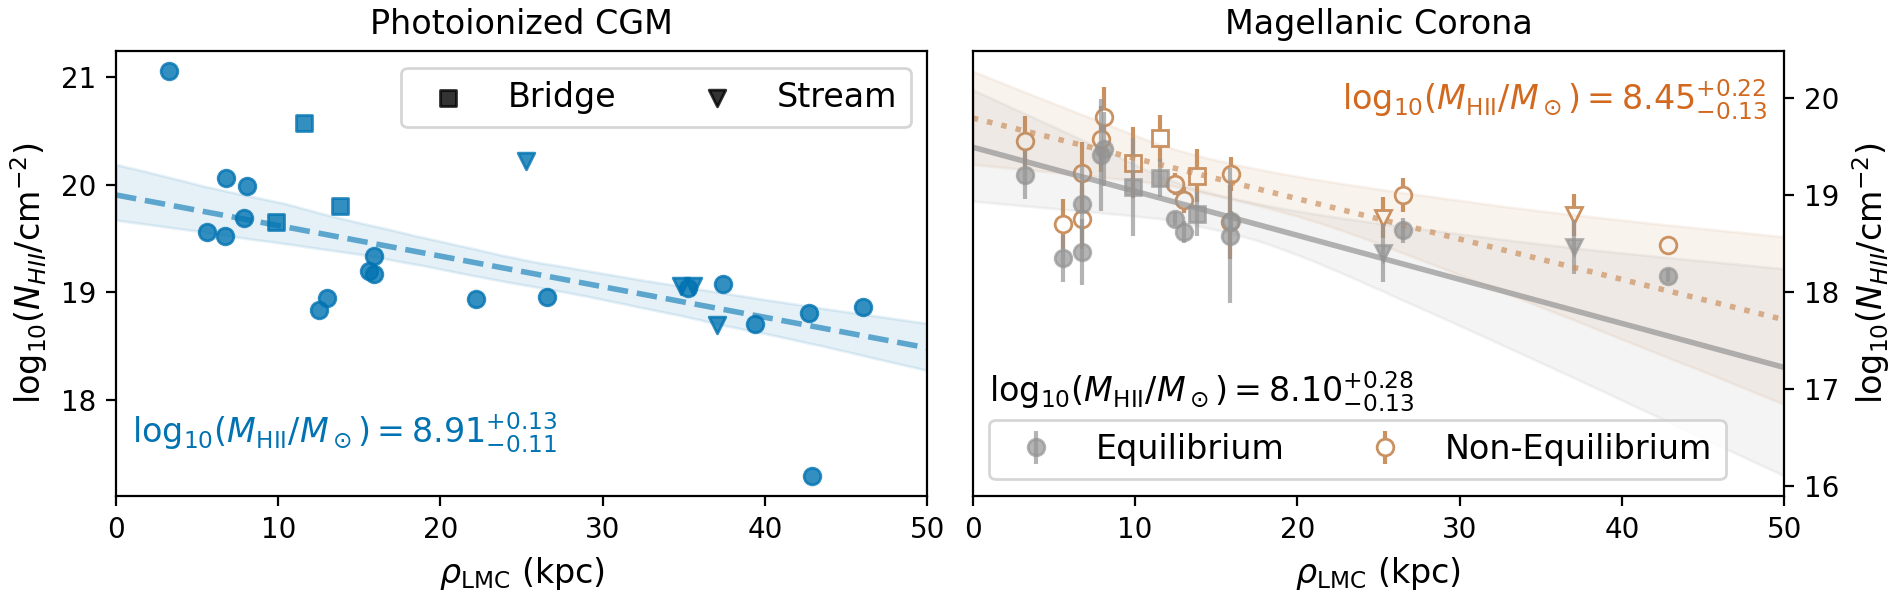

Text(0.5, 1.0, 'Magellanic Corona')

In [20]:
xx = np.linspace(0,50,1000)


fig = plt.figure(constrained_layout=True, figsize = (9.5,3))
mosaic = """
    BC
"""
axs = fig.subplot_mosaic(mosaic)

ax = axs["B"]

ax.scatter(impact_pars[rest_mask], np.log10(summed_N_HII.value)[rest_mask], 
           color = pal[0], alpha = 0.8)

ax.scatter(impact_pars[bridge_mask], np.log10(summed_N_HII.value)[bridge_mask], 
           color = pal[0], marker = "s", facecolor=pal[0], edgecolor = pal[0], 
           alpha = 0.8, label = "Bridge", lw = 1)

ax.scatter(impact_pars[stream_mask], np.log10(summed_N_HII.value)[stream_mask], 
           color = pal[0], marker = "v", facecolor=pal[0], edgecolor = pal[0], 
           alpha = 0.8, label = "Stream", lw = 1)



# ax.set_xlabel("LMC Impact Parameter (kpc)", fontsize = 12)


xlim = ax.get_xlim()


xxx = np.linspace(0,50,100)
def yy(xx, slope = slope.mean(), intercept = intercept.mean()):
    return slope*xx + intercept
ax.plot(xxx, yy(xxx), color = pal[0], lw = 2, alpha = 0.6,  ls = "--",
#         label = r"Slope = ${0:.3f} \pm {1:.3f}$".format(mean_slope, std_slope),
       )


# ax.plot(xx, med, color = pal[1], label = "Median Bootstrap")
ax.fill_between(xx, lo, hi, color = pal[0], alpha = 0.1)

lg = ax.legend(fontsize = 12, loc = 1, ncol = 2)
for lh in lg.legendHandles: 
    lh.set_color("k")

xlim = ax.set_xlim(0,50)


ax.text(1, 17.9, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$= {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(log_med_mass, 
                                                                                          log_plus_mass_err, 
                                                                                          log_minus_mass_err),
       ha = "left", va = "top", fontsize = 12, color = pal[0])

# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()

# ax.xaxis.tick_top()

ax.set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
ax.set_ylabel(r"$\log_{10}(N_{HII}/\mathrm{cm}^{-2})$", fontsize = 12)

# High Ions
ax1 = axs["C"]

ax1.set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
# ax1.set_ylabel(r"$\log_{10}(N_{HII}/\mathrm{cm}^{-2})$", fontsize = 12)

XX = high_ion_data["b"]
v150_z_CIV_10_err = high_ion_data["CIV_err"]
first_v150_z_NHII_from_CIV_10 = high_ion_data["HII"]
first_v150_z_NHII_from_CIV_10_err = high_ion_data["HII_err"]

# upper_lim_S = v150_z_SiIV_10_err < 0
upper_lim_C = v150_z_CIV_10_err < 0

# stream_S = np.array([x in stream_Bs for x in XX])
stream_C = np.array([x in high_ion_data["stream_Bs"] for x in XX])
# bridge_S = np.array([x in bridge_Bs for x in XX])
bridge_C = np.array([x in high_ion_data["bridge_Bs"] for x in XX])

ax1.scatter(XX[upper_lim_C ], first_v150_z_NHII_from_CIV_10[upper_lim_C], 
           color = pal[7], marker = "P", s = 75)

ax1.set_ylabel(r"$\log_{10}(N_{HII}/\mathrm{cm}^{-2})$", fontsize = 12)

#add arrows
for x,y in zip(XX[upper_lim_C], first_v150_z_NHII_from_CIV_10[upper_lim_C]):
    ax1.arrow(x,y,0,-0.25,color = pal[7], head_width = .5, head_length = .05)
    



ax1.errorbar(XX[~upper_lim_C & stream_C], first_v150_z_NHII_from_CIV_10[~upper_lim_C & stream_C], 
                  first_v150_z_NHII_from_CIV_10_err[~upper_lim_C & stream_C], fmt = "v", 
                  color=pal[7], alpha = 0.7)


ax1.errorbar(XX[~upper_lim_C & bridge_C], first_v150_z_NHII_from_CIV_10[~upper_lim_C & bridge_C], 
                  first_v150_z_NHII_from_CIV_10_err[~upper_lim_C & bridge_C], fmt = "s", 
                  color=pal[7], alpha = 0.7)


ax1.errorbar(XX[~upper_lim_C & ~stream_C & ~bridge_C], 
            first_v150_z_NHII_from_CIV_10[~upper_lim_C & ~stream_C & ~bridge_C], 
                  first_v150_z_NHII_from_CIV_10_err[~upper_lim_C & ~stream_C & ~bridge_C], fmt = "o", 
                  color=pal[7], alpha = 0.7, label = "Equilibrium")


# ax1.plot(xx, first_mean_line_C, color = pal[4], lw = 2, alpha = 0.7, 
#         label = r"Slope = ${0:.3f} \pm {1:.3f}$".format(first_mean_slope_C, first_std_slope_C))
# ax1.fill_between(xx, first_lo_line_C, first_hi_line_C, color = pal[4], alpha = 0.1)

ax1.plot(xx, gt7_first_mean_line_C, color = pal[7], lw = 2, alpha = 0.7, ls = "-",
#         label = r"Slope (> 7kpc) = ${0:.3f} \pm {1:.3f}$".format(gt7_first_mean_slope_C, gt7_first_std_slope_C),
        )
ax1.fill_between(xx, gt7_first_lo_line_C, gt7_first_hi_line_C, color = pal[7], alpha = 0.1)

ax1.set_xlim(0,50)



# ax1.text(49, 21.2, r"$\log_{{10}}(M_\mathrm{{HII,Corona}}/M_\odot$)$= {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(first_C_log_med_mass, 
#                                                                                           first_C_log_plus_mass_err, 
#                                                                                           first_C_log_minus_mass_err), 
#         ha = "right", va = "top", color = pal[4], fontsize = 12)


ax1.text(1, 17.2, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$= {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(gt7_first_C_log_med_mass, 
                                                                                          gt7_first_C_log_plus_mass_err, 
                                                                                          gt7_first_C_log_minus_mass_err), 
        ha = "left", va = "top", color = "k", fontsize = 12)

# lg = ax1.legend(fontsize = 12, loc = 1)

# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()




# ax.set_title("Low Ions; Photoionized (Cloudy)", fontsize = 12)
# ax1.set_title("High Ions; Corona (CIE)", fontsize = 12)



ylim_in = ax.get_ylim()
ylim2_in = ax1.get_ylim()




ax = axs["C"]



XX = high_ion_data["b"]
ISOCh_v150_z_CIV_10_err = high_ion_data["CIV_err"]
ISOCh_v150_z_NHII_from_CIV_10 = high_ion_data["ISOCh_HII"]
ISOCh_v150_z_NHII_from_CIV_10_err = high_ion_data["ISOCh_HII_err"]

# upper_lim_S = v150_z_SiIV_10_err < 0
upper_lim_C = ISOCh_v150_z_CIV_10_err < 0

# stream_S = np.array([x in stream_Bs for x in XX])
stream_C = np.array([x in high_ion_data["stream_Bs"] for x in XX])
# bridge_S = np.array([x in bridge_Bs for x in XX])
bridge_C = np.array([x in high_ion_data["bridge_Bs"] for x in XX])

ax.scatter(XX[upper_lim_C ], ISOCh_v150_z_NHII_from_CIV_10[upper_lim_C], 
           color = pal[5], marker = "P", s = 75)



#add arrows
for x,y in zip(XX[upper_lim_C], ISOCh_v150_z_NHII_from_CIV_10[upper_lim_C]):
    ax.arrow(x,y,0,-0.25,color = pal[5], head_width = .5, head_length = .05)
    



ax.errorbar(XX[~upper_lim_C & stream_C], ISOCh_v150_z_NHII_from_CIV_10[~upper_lim_C & stream_C], 
                  ISOCh_v150_z_NHII_from_CIV_10_err[~upper_lim_C & stream_C], fmt = "v", 
                  color=pal[5], mfc="w", zorder = -1)


ax.errorbar(XX[~upper_lim_C & bridge_C], ISOCh_v150_z_NHII_from_CIV_10[~upper_lim_C & bridge_C], 
                  ISOCh_v150_z_NHII_from_CIV_10_err[~upper_lim_C & bridge_C], fmt = "s", 
                  color=pal[5], mfc="w", zorder = -1)


ax.errorbar(XX[~upper_lim_C & ~stream_C & ~bridge_C], 
            ISOCh_v150_z_NHII_from_CIV_10[~upper_lim_C & ~stream_C & ~bridge_C], 
                  ISOCh_v150_z_NHII_from_CIV_10_err[~upper_lim_C & ~stream_C & ~bridge_C], fmt = "o", 
                  color=pal[5], mfc = "w", zorder = -1, label = "Non-Equilibrium")


# ax.plot(xx, ISOCh_mean_line_C, color = pal[4], lw = 2, alpha = 0.7, 
# #         label = r"Slope = ${0:.3f} \pm {1:.3f}$".format(ISOCh_mean_slope_C, ISOCh_std_slope_C),
#        )
# ax.fill_between(xx, ISOCh_lo_line_C, ISOCh_hi_line_C, color = pal[4], alpha = 0.1)

ax.plot(xx, ISOCh_gt7_mean_line_C, color = pal[5], lw = 2, alpha = 0.7, ls = ":",
#         label = r"Slope (> 7kpc) = ${0:.3f} \pm {1:.3f}$".format(ISOCh_gt7_mean_slope_C, ISOCh_gt7_std_slope_C),
       )
ax.fill_between(xx, ISOCh_gt7_lo_line_C, ISOCh_gt7_hi_line_C, color = pal[5], alpha = 0.1)

ax.set_xlim(0,50)


ax.text(49, 20.2, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$= {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(ISOCh_gt7_C_log_med_mass, 
                                                                                          ISOCh_gt7_C_log_plus_mass_err, 
                                                                                          ISOCh_gt7_C_log_minus_mass_err), 
        ha = "right", va = "top", color = "chocolate", fontsize = 12)


ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

lg = ax.legend(ncol = 2, fontsize = 12)

axs["B"].set_title("Photoionized CGM", fontsize = 12)
axs["C"].set_title("Magellanic Corona", fontsize = 12)

